In [1]:
%matplotlib inline
from matplotlib import pyplot
import geopandas
import numpy as np

from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.geometry import Polygon

from tile_units import TileUnit
from tile_map import Tiling

In [2]:
ak = geopandas.read_file("../data/imd-auckland-2018.gpkg")

# Cairo tiles [3<sup>2</sup>.4.3.4]
The one true tiling. Provides 4 directionally distinguishable elements... and also can be read two different ways (intersecting hexagons runninng in two orthogonal directions).

In [3]:
d = 500
tile_unit = TileUnit(spacing = d, crs = 2193)

<AxesSubplot:>

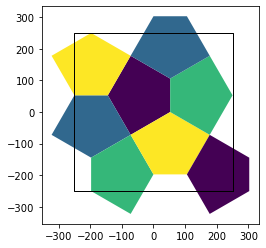

In [4]:
x = d / 2 * (np.sqrt(3) - 1) / 2 / np.sqrt(3)

poly1 = Polygon([
    (-d/2 + x, 0), (-d/4, -d/4), (0, -x), (0, x), (-d/4, d/4)
])
poly1 = translate(poly1, x, x)                                 # a
poly2 = rotate(poly1, 90, origin = poly1.exterior.coords[1])   # b
poly3 = rotate(poly1, 180, origin = poly1.exterior.coords[1])  # c
poly4 = rotate(poly1, 270, origin = poly1.exterior.coords[1])  # d
poly5 = rotate(poly4, 90, origin = poly4.exterior.coords[4])   # a 
poly6 = rotate(poly4, 270, origin = poly4.exterior.coords[4])  # c
poly7 = rotate(poly6, 270, origin = poly6.exterior.coords[1])  # b
poly8 = rotate(poly7, 180, origin = poly7.exterior.coords[4])  # d

tile_unit.elements = geopandas.GeoDataFrame(
    data = {"element_id": list("abcdacbd")}, crs = ak.crs,
    geometry = geopandas.GeoSeries(
        [poly1, poly2, poly3, poly4, poly5, poly6, poly7, poly8]))

ax = tile_unit.elements.plot(column = "element_id", cmap = "viridis")
tile_unit.tile.plot(ax = ax, edgecolor = "k", facecolor = "#00000000")

In [5]:
tiling = Tiling(tile_unit, ak, id_var = "DZ2018")
t30 = tiling.get_tiled_map(prioritise_tiles = True)

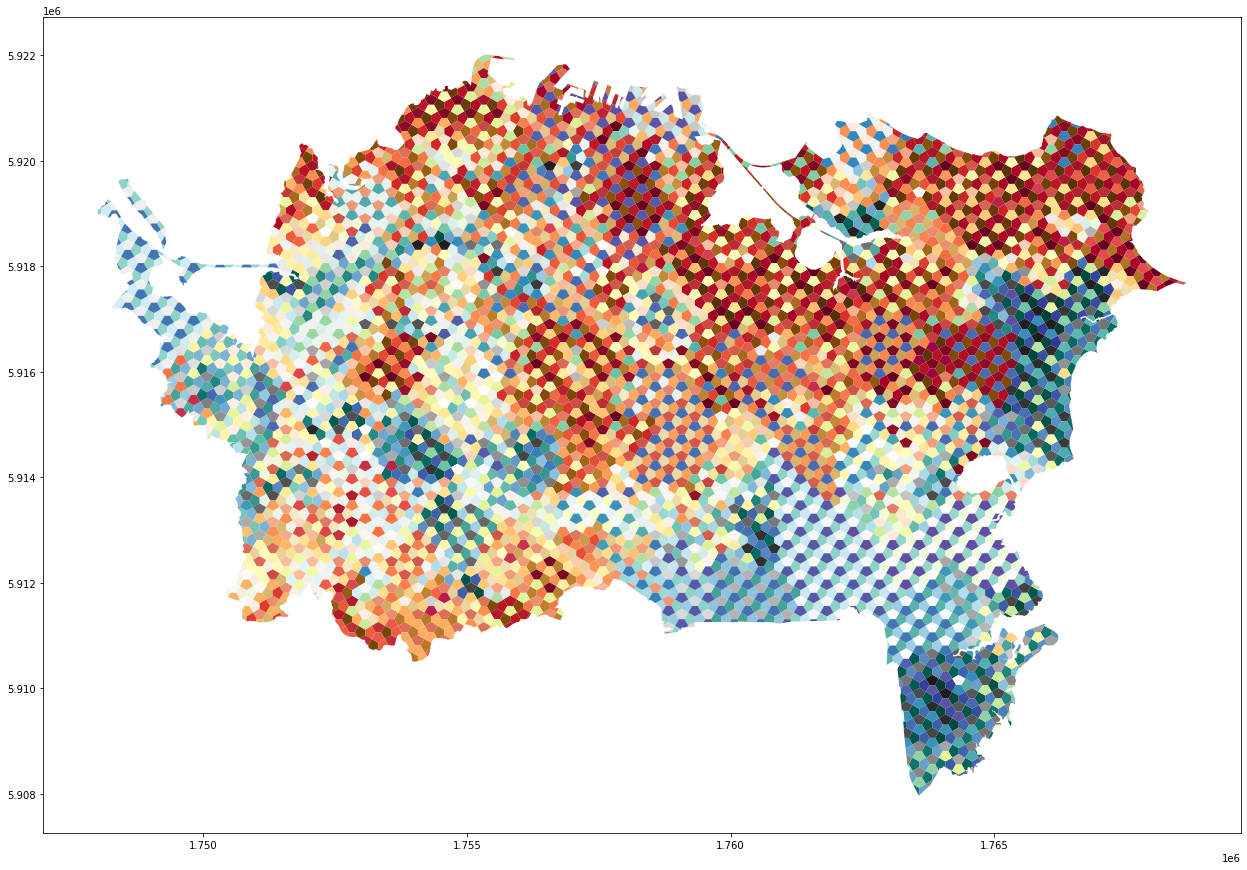

In [6]:
fig = pyplot.figure(figsize = (24, 15))
ax = fig.add_subplot(111)

strands = set(t30.element_id)
cols = [x for x in t30.columns if "Rank" in x]
cmaps = ("BrBG", "RdGy", "RdYlBu", "Spectral",
         "PiYG", "PRGn", "PuOr", "viridis")

for strand, col, cmap in zip(strands, cols, cmaps):
    t30[t30.element_id == strand].plot(ax = ax, column = col, cmap = cmap)